# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "module_name": "kgcnn.literature.Schnet", 
    "class_name":"make_model", 
    "output_as_dict":True,
    "config":{
        "name": "Schnet",
        "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                   {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                   {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
        "make_distance": True, "expand_distance": True,
        "interaction_args": {"units": 128, "use_bias": True,
                             "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
        "verbose": 10,
        "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                     "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
        "output_embedding": "graph", "output_to_tensor": True,
        "use_output_mlp": True,
        "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                       "activation": ["kgcnn>shifted_softplus", "linear"]}},
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model.model_config["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 6s 30ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 11s - loss: 18.9779 - energy_loss: 0.2429 - force_loss: 0.9368 - 11s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9331 - energy_loss: 0.2085 - force_loss: 0.9362 - 563ms/epoch - 70ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.9241 - energy_loss: 0.2110 - force_loss: 0.9357 - 564ms/epoch - 70ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.8911 - energy_loss: 0.2100 - force_loss: 0.9341 - 583ms/epoch - 73ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.7384 - energy_loss: 0.2636 - force_loss: 0.9237 - 558ms/epoch - 70ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.6436 - energy_loss: 0.5522 - force_loss: 0.9046 - 545ms/epoch - 68ms/step
Epoch 7/1500
8/8 - 1s - loss: 18.5170 - energy_loss: 0.4830 - force_loss: 0.9017 - 537ms/epoch - 67ms/step
Epoch 8/1500
8/8 - 1s - loss: 18.0424 - energy_loss: 0.3260 - force_loss: 0.8858 - 580ms/epoch - 73ms/step
Epoch 9/1500
8/8 - 1s - loss: 17.9840 - energy_loss: 1.1626 - force_loss: 0.8411 - 542ms/epoch - 68ms/step
Epoch 10/1500
8/8 - 1s - loss: 17.5002 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 7.4145 - energy_loss: 1.3335 - force_loss: 0.3041 - 555ms/epoch - 69ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.5827 - energy_loss: 0.4495 - force_loss: 0.3067 - 543ms/epoch - 68ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.1789 - energy_loss: 0.4103 - force_loss: 0.2884 - 539ms/epoch - 67ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.4659 - energy_loss: 0.7907 - force_loss: 0.2838 - 540ms/epoch - 68ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.7435 - energy_loss: 0.7136 - force_loss: 0.3015 - 531ms/epoch - 66ms/step
Epoch 83/1500
8/8 - 1s - loss: 7.0406 - energy_loss: 1.0447 - force_loss: 0.2998 - 548ms/epoch - 69ms/step
Epoch 84/1500
8/8 - 1s - loss: 7.2396 - energy_loss: 1.0140 - force_loss: 0.3113 - 581ms/epoch - 73ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.9990 - energy_loss: 1.0683 - force_loss: 0.2965 - 620ms/epoch - 77ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.3128 - energy_loss: 0.6976 - force_loss: 0.2808 - 619ms/epoch - 77ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.0378

8/8 - 1s - loss: 4.4261 - energy_loss: 0.3808 - force_loss: 0.2023 - 539ms/epoch - 67ms/step
Epoch 155/1500
8/8 - 1s - loss: 5.1378 - energy_loss: 0.6665 - force_loss: 0.2236 - 544ms/epoch - 68ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.4916 - energy_loss: 0.4269 - force_loss: 0.2032 - 537ms/epoch - 67ms/step
Epoch 157/1500
8/8 - 1s - loss: 5.3011 - energy_loss: 0.7929 - force_loss: 0.2254 - 541ms/epoch - 68ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.7170 - energy_loss: 0.6396 - force_loss: 0.2039 - 545ms/epoch - 68ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.4712 - energy_loss: 0.6101 - force_loss: 0.1931 - 548ms/epoch - 69ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.6133 - energy_loss: 0.6175 - force_loss: 0.1998 - 550ms/epoch - 69ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.1871 - energy_loss: 0.2897 - force_loss: 0.1949 - 550ms/epoch - 69ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.0274 - energy_loss: 0.2618 - force_loss: 0.1883 - 540ms/epoch - 68ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.0395 - en

Epoch 230/1500
8/8 - 1s - loss: 3.5168 - energy_loss: 0.2620 - force_loss: 0.1627 - 551ms/epoch - 69ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.6193 - energy_loss: 0.5598 - force_loss: 0.1530 - 558ms/epoch - 70ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.8483 - energy_loss: 0.5858 - force_loss: 0.1631 - 540ms/epoch - 68ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.9243 - energy_loss: 0.6087 - force_loss: 0.1658 - 539ms/epoch - 67ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.9157 - energy_loss: 0.5945 - force_loss: 0.1661 - 533ms/epoch - 67ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.7774 - energy_loss: 0.5665 - force_loss: 0.1605 - 553ms/epoch - 69ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.6530 - energy_loss: 0.5576 - force_loss: 0.1548 - 536ms/epoch - 67ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.6212 - energy_loss: 0.5644 - force_loss: 0.1528 - 544ms/epoch - 68ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.5561 - energy_loss: 0.5563 - force_loss: 0.1500 - 533ms/epoch - 67ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.2056 - energy_loss: 0.3602 - force_loss: 0.1423 - 540ms/epoch - 68ms/step
Epoch 307/1500
8/8 - 1s - loss: 2.8764 - energy_loss: 0.1985 - force_loss: 0.1339 - 542ms/epoch - 68ms/step
Epoch 308/1500
8/8 - 1s - loss: 2.9419 - energy_loss: 0.2710 - force_loss: 0.1335 - 541ms/epoch - 68ms/step
Epoch 309/1500
8/8 - 1s - loss: 3.4336 - energy_loss: 0.7332 - force_loss: 0.1350 - 546ms/epoch - 68ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.5145 - energy_loss: 0.8060 - force_loss: 0.1354 - 558ms/epoch - 70ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.4795 - energy_loss: 0.6537 - force_loss: 0.1413 - 540ms/epoch - 68ms/step
Epoch 312/1500
8/8 - 1s - loss: 2.9639 - energy_loss: 0.2569 - force_loss: 0.1353 - 546ms/epoch - 68ms/step
Epoch 313/1500
8/8 - 1s - loss: 2.8941 - energy_loss: 0.2512 - force_loss: 0.1321 - 561ms/epoch - 70ms/step
Epoch 314/1500
8/8 - 1s - loss: 2.8783 - energy_loss: 0.2306 - force_loss: 0.1324 - 572ms/epoch - 71ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 2.8511 - energy_loss: 0.2331 - force_loss: 0.1309 - 554ms/epoch - 69ms/step
Epoch 383/1500
8/8 - 1s - loss: 3.0385 - energy_loss: 0.4374 - force_loss: 0.1301 - 569ms/epoch - 71ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.6101 - energy_loss: 0.8801 - force_loss: 0.1365 - 562ms/epoch - 70ms/step
Epoch 385/1500
8/8 - 1s - loss: 2.8635 - energy_loss: 0.2272 - force_loss: 0.1318 - 545ms/epoch - 68ms/step
Epoch 386/1500
8/8 - 1s - loss: 2.8900 - energy_loss: 0.4365 - force_loss: 0.1227 - 547ms/epoch - 68ms/step
Epoch 387/1500
8/8 - 1s - loss: 3.1392 - energy_loss: 0.7174 - force_loss: 0.1211 - 544ms/epoch - 68ms/step
Epoch 388/1500
8/8 - 1s - loss: 3.1887 - energy_loss: 0.5616 - force_loss: 0.1314 - 544ms/epoch - 68ms/step
Epoch 389/1500
8/8 - 1s - loss: 3.2772 - energy_loss: 0.5018 - force_loss: 0.1388 - 550ms/epoch - 69ms/step
Epoch 390/1500
8/8 - 1s - loss: 3.1613 - energy_loss: 0.5163 - force_loss: 0.1323 - 551ms/epoch - 69ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 2.7954 - energy_loss: 0.3838 - force_loss: 0.1206 - 534ms/epoch - 67ms/step
Epoch 459/1500
8/8 - 1s - loss: 2.6004 - energy_loss: 0.2198 - force_loss: 0.1190 - 556ms/epoch - 69ms/step
Epoch 460/1500
8/8 - 1s - loss: 2.7709 - energy_loss: 0.3674 - force_loss: 0.1202 - 536ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 3.0189 - energy_loss: 0.5156 - force_loss: 0.1252 - 541ms/epoch - 68ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.9834 - energy_loss: 0.4361 - force_loss: 0.1274 - 540ms/epoch - 68ms/step
Epoch 463/1500
8/8 - 1s - loss: 2.7366 - energy_loss: 0.4585 - force_loss: 0.1139 - 545ms/epoch - 68ms/step
Epoch 464/1500
8/8 - 1s - loss: 2.6439 - energy_loss: 0.4344 - force_loss: 0.1105 - 543ms/epoch - 68ms/step
Epoch 465/1500
8/8 - 1s - loss: 2.6507 - energy_loss: 0.4226 - force_loss: 0.1114 - 532ms/epoch - 67ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.8248 - energy_loss: 0.4206 - force_loss: 0.1202 - 568ms/epoch - 71ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.5748 - energy_loss: 0.4179 - force_loss: 0.1078 - 575ms/epoch - 72ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.5056 - energy_loss: 0.3984 - force_loss: 0.1054 - 545ms/epoch - 68ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.4987 - energy_loss: 0.4204 - force_loss: 0.1039 - 552ms/epoch - 69ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.5719 - energy_loss: 0.5300 - force_loss: 0.1021 - 634ms/epoch - 79ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.8775 - energy_loss: 0.7660 - force_loss: 0.1056 - 654ms/epoch - 82ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.8548 - energy_loss: 0.6485 - force_loss: 0.1103 - 603ms/epoch - 75ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.5296 - energy_loss: 0.2452 - force_loss: 0.1142 - 580ms/epoch - 72ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.2657 - energy_loss: 0.1737 - force_loss: 0.1046 - 551ms/epoch - 69ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.3076 - energy_loss: 0.2681 - force_loss: 0.1020 - 547ms/epoch - 68ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.8797 - energy_loss: 0.4634 - force_loss: 0.1208 - 564ms/epoch - 71ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.5505 - energy_loss: 0.3961 - force_loss: 0.1077 - 568ms/epoch - 71ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.5034 - energy_loss: 0.4255 - force_loss: 0.1039 - 558ms/epoch - 70ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.4540 - energy_loss: 0.3781 - force_loss: 0.1038 - 564ms/epoch - 71ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.4049 - energy_loss: 0.2654 - force_loss: 0.1070 - 571ms/epoch - 71ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.4421 - energy_loss: 0.3951 - force_loss: 0.1024 - 580ms/epoch - 72ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.4075 - energy_loss: 0.4022 - force_loss: 0.1003 - 598ms/epoch - 75ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.3977 - energy_loss: 0.3988 - force_loss: 0.0999 - 552ms/epoch - 69ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.4264 - energy_loss: 0.3784 - force_loss: 0.1024 - 553ms/epoch - 69ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 2.1195 - energy_loss: 0.1889 - force_loss: 0.0965 - 528ms/epoch - 66ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.0231 - energy_loss: 0.1828 - force_loss: 0.0920 - 549ms/epoch - 69ms/step
Epoch 688/1500
8/8 - 1s - loss: 1.9901 - energy_loss: 0.1965 - force_loss: 0.0897 - 543ms/epoch - 68ms/step
Epoch 689/1500
8/8 - 1s - loss: 1.9669 - energy_loss: 0.1970 - force_loss: 0.0885 - 534ms/epoch - 67ms/step
Epoch 690/1500
8/8 - 1s - loss: 1.9520 - energy_loss: 0.1846 - force_loss: 0.0884 - 555ms/epoch - 69ms/step
Epoch 691/1500
8/8 - 1s - loss: 1.9742 - energy_loss: 0.1990 - force_loss: 0.0888 - 545ms/epoch - 68ms/step
Epoch 692/1500
8/8 - 1s - loss: 1.9406 - energy_loss: 0.1812 - force_loss: 0.0880 - 552ms/epoch - 69ms/step
Epoch 693/1500
8/8 - 1s - loss: 1.9851 - energy_loss: 0.1826 - force_loss: 0.0901 - 539ms/epoch - 67ms/step
Epoch 694/1500
8/8 - 1s - loss: 1.9741 - energy_loss: 0.1942 - force_loss: 0.0890 - 542ms/epoch - 68ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 1.9278 - energy_loss: 0.1968 - force_loss: 0.0865 - 537ms/epoch - 67ms/step
Epoch 763/1500
8/8 - 1s - loss: 1.8885 - energy_loss: 0.2088 - force_loss: 0.0840 - 543ms/epoch - 68ms/step
Epoch 764/1500
8/8 - 1s - loss: 1.9095 - energy_loss: 0.2044 - force_loss: 0.0853 - 539ms/epoch - 67ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.2502 - energy_loss: 0.4730 - force_loss: 0.0889 - 530ms/epoch - 66ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.2394 - energy_loss: 0.3916 - force_loss: 0.0924 - 528ms/epoch - 66ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.2137 - energy_loss: 0.2172 - force_loss: 0.0998 - 535ms/epoch - 67ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.1965 - energy_loss: 0.2008 - force_loss: 0.0998 - 551ms/epoch - 69ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.0372 - energy_loss: 0.1543 - force_loss: 0.0941 - 547ms/epoch - 68ms/step
Epoch 770/1500
8/8 - 1s - loss: 1.9282 - energy_loss: 0.2004 - force_loss: 0.0864 - 549ms/epoch - 69ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 2.0434 - energy_loss: 0.3834 - force_loss: 0.0830 - 542ms/epoch - 68ms/step
Epoch 839/1500
8/8 - 1s - loss: 2.0532 - energy_loss: 0.3329 - force_loss: 0.0860 - 575ms/epoch - 72ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.1209 - energy_loss: 0.3893 - force_loss: 0.0866 - 624ms/epoch - 78ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.0983 - energy_loss: 0.3905 - force_loss: 0.0854 - 602ms/epoch - 75ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.0786 - energy_loss: 0.3390 - force_loss: 0.0870 - 557ms/epoch - 70ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.1087 - energy_loss: 0.3706 - force_loss: 0.0869 - 558ms/epoch - 70ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.1024 - energy_loss: 0.3565 - force_loss: 0.0873 - 554ms/epoch - 69ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.1582 - energy_loss: 0.3491 - force_loss: 0.0905 - 556ms/epoch - 70ms/step
Epoch 846/1500
8/8 - 1s - loss: 2.2750 - energy_loss: 0.3804 - force_loss: 0.0947 - 580ms/epoch - 72ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 2.2763 - energy_loss: 0.3697 - force_loss: 0.0953 - 537ms/epoch - 67ms/step
Epoch 915/1500
8/8 - 1s - loss: 2.2201 - energy_loss: 0.3527 - force_loss: 0.0934 - 536ms/epoch - 67ms/step
Epoch 916/1500
8/8 - 1s - loss: 2.1633 - energy_loss: 0.3596 - force_loss: 0.0902 - 553ms/epoch - 69ms/step
Epoch 917/1500
8/8 - 1s - loss: 2.1028 - energy_loss: 0.3586 - force_loss: 0.0872 - 536ms/epoch - 67ms/step
Epoch 918/1500
8/8 - 1s - loss: 2.0973 - energy_loss: 0.3543 - force_loss: 0.0871 - 534ms/epoch - 67ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.1562 - energy_loss: 0.3481 - force_loss: 0.0904 - 531ms/epoch - 66ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.1275 - energy_loss: 0.3624 - force_loss: 0.0883 - 538ms/epoch - 67ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.0519 - energy_loss: 0.3476 - force_loss: 0.0852 - 556ms/epoch - 69ms/step
Epoch 922/1500
8/8 - 1s - loss: 2.0454 - energy_loss: 0.3484 - force_loss: 0.0849 - 529ms/epoch - 66ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.1852 - energy_loss: 0.3646 - force_loss: 0.0910 - 545ms/epoch - 68ms/step
Epoch 991/1500
8/8 - 1s - loss: 2.2514 - energy_loss: 0.3937 - force_loss: 0.0929 - 548ms/epoch - 69ms/step
Epoch 992/1500
8/8 - 1s - loss: 2.1163 - energy_loss: 0.3086 - force_loss: 0.0904 - 547ms/epoch - 68ms/step
Epoch 993/1500
8/8 - 1s - loss: 2.2661 - energy_loss: 0.5286 - force_loss: 0.0869 - 540ms/epoch - 68ms/step
Epoch 994/1500
8/8 - 1s - loss: 2.5891 - energy_loss: 0.8751 - force_loss: 0.0857 - 539ms/epoch - 67ms/step
Epoch 995/1500
8/8 - 1s - loss: 2.7467 - energy_loss: 1.0326 - force_loss: 0.0857 - 545ms/epoch - 68ms/step
Epoch 996/1500
8/8 - 1s - loss: 2.5259 - energy_loss: 0.6725 - force_loss: 0.0927 - 535ms/epoch - 67ms/step
Epoch 997/1500
8/8 - 1s - loss: 2.0476 - energy_loss: 0.1918 - force_loss: 0.0928 - 536ms/epoch - 67ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.3871 - energy_loss: 0.3913 - force_loss: 0.0998 - 530ms/epoch - 66ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.7674 - energy_loss: 0.1580 - force_loss: 0.0805 - 554ms/epoch - 69ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.8144 - energy_loss: 0.1713 - force_loss: 0.0822 - 560ms/epoch - 70ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.7753 - energy_loss: 0.1482 - force_loss: 0.0814 - 531ms/epoch - 66ms/step
Epoch 1069/1500
8/8 - 1s - loss: 1.7258 - energy_loss: 0.1487 - force_loss: 0.0789 - 529ms/epoch - 66ms/step
Epoch 1070/1500
8/8 - 1s - loss: 1.7367 - energy_loss: 0.1895 - force_loss: 0.0774 - 528ms/epoch - 66ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.7118 - energy_loss: 0.1673 - force_loss: 0.0772 - 533ms/epoch - 67ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.7591 - energy_loss: 0.2416 - force_loss: 0.0759 - 530ms/epoch - 66ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.9089 - energy_loss: 0.3568 - force_loss: 0.0776 - 530ms/epoch - 66ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.9896 - energy_loss: 0.3393 - force_loss: 0.0825 - 546ms/epoch - 68ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.6268 - energy_loss: 0.1790 - force_loss: 0.0724 - 531ms/epoch - 66ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.5945 - energy_loss: 0.1592 - force_loss: 0.0718 - 530ms/epoch - 66ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.5970 - energy_loss: 0.1627 - force_loss: 0.0717 - 531ms/epoch - 66ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.5809 - energy_loss: 0.1513 - force_loss: 0.0715 - 532ms/epoch - 67ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.9556 - energy_loss: 0.4733 - force_loss: 0.0741 - 532ms/epoch - 67ms/step
Epoch 1147/1500
8/8 - 1s - loss: 2.1321 - energy_loss: 0.5458 - force_loss: 0.0793 - 528ms/epoch - 66ms/step
Epoch 1148/1500
8/8 - 1s - loss: 2.0221 - energy_loss: 0.3839 - force_loss: 0.0819 - 548ms/epoch - 69ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.9153 - energy_loss: 0.2928 - force_loss: 0.0811 - 541ms/epoch - 68ms/step
Epoch 1150/1500
8/8 - 1s - loss: 2.0331 - energy_loss: 0.3435 - force_loss: 0.0845 - 531ms/epoch - 66ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.4802 - energy_loss: 0.1425 - force_loss: 0.0669 - 540ms/epoch - 67ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8369 - energy_loss: 0.4363 - force_loss: 0.0700 - 535ms/epoch - 67ms/step
Epoch 1220/1500
8/8 - 1s - loss: 2.0360 - energy_loss: 0.4927 - force_loss: 0.0772 - 529ms/epoch - 66ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.8808 - energy_loss: 0.3403 - force_loss: 0.0770 - 535ms/epoch - 67ms/step
Epoch 1222/1500
8/8 - 1s - loss: 2.1915 - energy_loss: 0.6496 - force_loss: 0.0771 - 534ms/epoch - 67ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.9450 - energy_loss: 0.4205 - force_loss: 0.0762 - 529ms/epoch - 66ms/step
Epoch 1224/1500
8/8 - 1s - loss: 2.1461 - energy_loss: 0.5993 - force_loss: 0.0773 - 534ms/epoch - 67ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.8732 - energy_loss: 0.2929 - force_loss: 0.0790 - 533ms/epoch - 67ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.8739 - energy_loss: 0.3210 - force_loss: 0.0776 - 531ms/epoch - 66ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.8601 - energy_loss: 0.3168 - force_loss: 0.0772 - 547ms/epoch - 68ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.8443 - energy_loss: 0.3014 - force_loss: 0.0771 - 550ms/epoch - 69ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.8615 - energy_loss: 0.3434 - force_loss: 0.0759 - 551ms/epoch - 69ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.9451 - energy_loss: 0.3232 - force_loss: 0.0811 - 541ms/epoch - 68ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.7750 - energy_loss: 0.2578 - force_loss: 0.0759 - 546ms/epoch - 68ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.8616 - energy_loss: 0.3032 - force_loss: 0.0779 - 553ms/epoch - 69ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.7411 - energy_loss: 0.2881 - force_loss: 0.0726 - 535ms/epoch - 67ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.7128 - energy_loss: 0.2897 - force_loss: 0.0712 - 529ms/epoch - 66ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.8112 - energy_loss: 0.2606 - force_loss: 0.0775 - 531ms/epoch - 66ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.8321 - energy_loss: 0.3296 - force_loss: 0.0751 - 533ms/epoch - 67ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.5602 - energy_loss: 0.1444 - force_loss: 0.0708 - 538ms/epoch - 67ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.4803 - energy_loss: 0.1425 - force_loss: 0.0669 - 539ms/epoch - 67ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.5581 - energy_loss: 0.1454 - force_loss: 0.0706 - 539ms/epoch - 67ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.5941 - energy_loss: 0.2307 - force_loss: 0.0682 - 536ms/epoch - 67ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.8715 - energy_loss: 0.5465 - force_loss: 0.0663 - 548ms/epoch - 69ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.9434 - energy_loss: 0.6222 - force_loss: 0.0661 - 553ms/epoch - 69ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.8156 - energy_loss: 0.4834 - force_loss: 0.0666 - 547ms/epoch - 68ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.7500 - energy_loss: 0.3762 - force_loss: 0.0687 - 559ms/epoch - 70ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.6028 - energy_loss: 0.2564 - force_loss: 0.0673 - 635ms/epoch - 79ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.5931 - energy_loss: 0.2802 - force_loss: 0.0656 - 596ms/epoch - 74ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.6002 - energy_loss: 0.2869 - force_loss: 0.0657 - 545ms/epoch - 68ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.5962 - energy_loss: 0.2922 - force_loss: 0.0652 - 538ms/epoch - 67ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.6346 - energy_loss: 0.2799 - force_loss: 0.0677 - 538ms/epoch - 67ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.5905 - energy_loss: 0.2710 - force_loss: 0.0660 - 550ms/epoch - 69ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.6261 - energy_loss: 0.2415 - force_loss: 0.0692 - 532ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.4646 - energy_loss: 0.1176 - force_loss: 0.0673 - 530ms/epoch - 66ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.4990 - energy_loss: 0.1459 - force_loss: 0.0677 - 563ms/epoch - 70ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

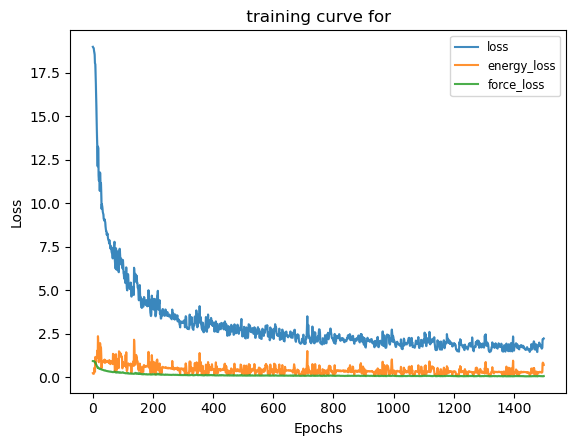

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.mdyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates= "coords")],
    model_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, force="forces", atomic_number="nuclear_charges")]
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape_1:0", shape=(None,), dtype=int64), values=Tensor("gradients/boolean_mask/GatherV2_grad/Reshape:0", shape=(None, 3), dtype=float32), dense_shape=Tensor("gradients/boolean_mask/GatherV2_grad/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


{'energy': array([-17470.586], dtype=float32),
 'forces': array([[-2.77357   ,  2.608604  , -0.72824687],
        [-0.8435056 , -0.79044414,  1.8988283 ],
        [ 3.2661834 , -2.2612574 , -0.16957062],
        [-0.4858059 ,  1.7778134 , -0.19855961],
        [ 0.03361735,  2.021931  ,  0.9989947 ],
        [-0.4754815 ,  0.22642493, -0.10011685],
        [ 0.31006157,  0.70153666, -2.202866  ],
        [-0.33438963, -1.1880902 , -0.06067455],
        [ 0.7297653 ,  4.018831  ,  2.1023922 ],
        [-0.7532232 ,  1.8735349 ,  0.7759566 ],
        [ 1.1307571 , -1.1866678 ,  0.59229994],
        [ 0.5617751 , -4.125223  , -2.131675  ],
        [ 1.757461  , -0.9986485 , -0.6676652 ],
        [-0.25037068, -0.55888176,  0.39934653],
        [ 1.1838567 , -1.8846889 ,  1.3858811 ],
        [ 0.08299611,  0.28779188, -0.8326772 ],
        [-1.1517341 ,  0.4048833 , -0.15672079],
        [-0.44988537,  0.46446007, -0.2677551 ],
        [-0.42269543, -1.1278076 , -0.73166203],
        [-0.

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.mdyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

{'energy': array(-17470.586, dtype=float32), 'forces': array([[-2.77357   ,  2.608604  , -0.72824657],
       [-0.84350634, -0.7904443 ,  1.8988287 ],
       [ 3.2661836 , -2.2612572 , -0.1695716 ],
       [-0.4858061 ,  1.7778127 , -0.19855917],
       [ 0.03361666,  2.021931  ,  0.99899507],
       [-0.47548223,  0.2264251 , -0.10011604],
       [ 0.31006157,  0.7015382 , -2.2028682 ],
       [-0.33438993, -1.1880907 , -0.06067427],
       [ 0.7297656 ,  4.0188303 ,  2.1023922 ],
       [-0.75322354,  1.873535  ,  0.7759576 ],
       [ 1.1307584 , -1.1866682 ,  0.59229785],
       [ 0.561774  , -4.125224  , -2.1316752 ],
       [ 1.7574627 , -0.99864894, -0.66766536],
       [-0.25037035, -0.5588814 ,  0.39934546],
       [ 1.183857  , -1.8846889 ,  1.3858818 ],
       [ 0.08299619,  0.28779197, -0.83267725],
       [-1.1517336 ,  0.40488324, -0.15672067],
       [-0.4498847 ,  0.46446002, -0.26775488],
       [-0.4226955 , -1.1278074 , -0.73166215],
       [-0.54114354,  0.36483458,

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.933eV  Ekin = 0.036eV (T=277K)  Etot = -831.897eV


Energy per atom: Epot = -831.950eV  Ekin = 0.053eV (T=410K)  Etot = -831.897eV
Energy per atom: Epot = -831.949eV  Ekin = 0.052eV (T=399K)  Etot = -831.897eV
Energy per atom: Epot = -831.947eV  Ekin = 0.049eV (T=381K)  Etot = -831.898eV
Energy per atom: Epot = -831.950eV  Ekin = 0.056eV (T=432K)  Etot = -831.894eV
Energy per atom: Epot = -831.954eV  Ekin = 0.059eV (T=460K)  Etot = -831.894eV
Energy per atom: Epot = -831.947eV  Ekin = 0.051eV (T=392K)  Etot = -831.897eV
Energy per atom: Epot = -831.949eV  Ekin = 0.052eV (T=404K)  Etot = -831.897eV
Energy per atom: Epot = -831.943eV  Ekin = 0.056eV (T=431K)  Etot = -831.888eV
Energy per atom: Epot = -831.938eV  Ekin = 0.044eV (T=337K)  Etot = -831.894eV
Energy per atom: Epot = -831.948eV  Ekin = 0.057eV (T=445K)  Etot = -831.890eV
Energy per atom: Epot = -831.939eV  Ekin = 0.049eV (T=378K)  Etot = -831.890eV
Energy per atom: Epot = -831.930eV  Ekin = 0.043eV (T=330K)  Etot = -831.887eV
Energy per atom: Epot = -831.926eV  Ekin = 0.047eV (